# Stake .csv to DDF and Plots

## Stake Class Auto Reload

In [1]:
%load_ext autoreload

%autoreload 2

## Imports

In [2]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
from stake_class import Stake
import math
import tkinter as tk
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

pd.options.mode.chained_assignment = None

## Stake Methods

In [3]:
def build_stake_dataset(stake_folder):
    global directory
    directory='/Users/cmarkovsky/Desktop/AK_REU/NEW_STAKES/Data/' #INSERT YOUR FILE DIRECTORY HERE
    stake_files=os.listdir(directory+stake_folder)
    coords_dict = {}
    stake_dict = {}
    melt_dict = {}
    DDF_dict = {}
    for file in stake_files:
        stake_name = file.replace('.csv','')
        cur_stake = Stake(directory, stake_folder, file)
        dates = cur_stake.df['date']
        surface_type = cur_stake.df['surface_type']
        if (not (dates.size < 2)) & ('Debris' in surface_type.values):
            cur_melt = cur_stake.get_melt()
            cur_ddf = determine_DDF(cur_melt)
            stake_dict[stake_name] = cur_stake
            melt_dict[stake_name] = cur_melt
            DDF_dict[stake_name] = cur_ddf
            coords_dict[stake_name] = cur_stake.coords
            
    full_dict = {'stake_info':stake_dict, 'melt_info':melt_dict, 'DDF_info':DDF_dict, 'coords_info':coords_dict}
    
    return full_dict

            

## AWS Methods

In [6]:
def build_AWS_dataset(AWS_file):
    ### Builds a dataset for the AWS data
    
    AWS_folder = 'AWS_data'
    try:  
        AWS_file=pd.read_csv(directory+AWS_folder+'/'+AWS_file)
    except IOError:
        print('ERROR: Could not find', AWS_file)
        return
    AWS_file['Date'] = AWS_changedate(AWS_file['Date'])
    return AWS_file
    
def AWS_changedate(date_list):
    ### Changes the dates into a readable and manipulable format
    
    new_dates = []
    for date in date_list:
        try:
            new_date = datetime.strptime(date, '%m/%d/%y %H:%M')
        except:
            new_date = -1
        new_dates.append(new_date)
    return new_dates

def days_between(date1, date2):
    ### Calculates the number of days between two dates
    
    """Calculate the number of days in between two dates"""
    delta=abs(date2-date1)
    return(delta.days)


## Stake and AWS Methods

In [7]:
def get_common_dates(melt_dates, AWS_dates):
    ### Determines the common date range for stake measurements and AWS measurements
    
    AWS_start_date = AWS_dates.iloc[0]
    AWS_end_date = AWS_dates.iloc[-1]
    AWS_2020_dates = AWS_dates.iloc[0:2209]
    AWS_2020_end = AWS_2020_dates.iloc[-1]
    model_dates = []
    for m in (range(melt_dates.size-1)):
        melt_start_date = melt_dates.iloc[m]
        melt_end_date = melt_dates.iloc[m+1]
        model_start_date = AWS_start_date
        
        model_end_date = AWS_end_date
        if melt_start_date.year == melt_end_date.year and melt_start_date.year > 2019:
            if not melt_start_date.year == 2020:
                if melt_start_date > AWS_start_date:
                    model_start_date = melt_start_date
                if melt_end_date < AWS_end_date:
                    model_end_date = melt_end_date
            else:
                model_end_date = AWS_2020_end
                if melt_start_date > AWS_start_date:
                    model_start_date = melt_start_date
                if melt_end_date < AWS_2020_end:
                    model_end_date = melt_end_date

            model_range = (model_start_date, model_end_date)
            model_dates.append(model_range)
    return model_dates

## MPD and DDF methods

In [8]:
def determine_DDF(melt):
    ### Determine the melt per day (mpd) and degree day factor (DDF) for each melt period
    
    AWS_file = build_AWS_dataset('AWS_infilled_2020-2021.csv')
    T = AWS_file['T_RTD']
    AWS_dates = AWS_file['Date']
    melt_dates = melt['melt_dates']
    model_dates = get_common_dates(melt_dates, AWS_dates)
    mpd_list = []
    DDF_list = []
    debris_list = []
    for date_range in model_dates:
        num_days = days_between(date_range[0], date_range[1])
        index=-1
        for m in range(melt_dates.size - 1):
            if melt_dates[m] == date_range[0]:
                index = m+1
                break
        if not index == -1:
            cur_mpd = melt.iloc[index][1] * 10 * 0.9 # (mm w.e./d)Convert to mm from cm
            
            total_melt = cur_mpd * num_days # (mm w.e.)
            
            cur_debris = melt['debris_depth'][index]
            cur_ele = melt['elevation'][index]
            i=1
            while math.isnan(cur_ele):
                cur_ele = melt['elevation'][index-i]
                if i > index:
                    break
                i += 1

            ele_factor = get_ele_factor(cur_ele, date_range[1].year)
            
            AWS_start = AWS_dates[AWS_dates == date_range[0]].index[0]
            
            AWS_end = AWS_dates[AWS_dates == date_range[1]].index[0]
            
            cur_PDD = (sum(T.iloc[AWS_start:AWS_end]) + len(T.iloc[AWS_start:AWS_end])*ele_factor) / 24 # ºC*d
            
            cur_DDF = total_melt / cur_PDD # mm w.e. / (ºC*d)
            debris_list.append(cur_debris)
            mpd_list.append(cur_mpd)
            DDF_list.append(cur_DDF)
            
    DDF_df = pd.DataFrame(model_dates, columns = ['start_date', 'end_date'])

    DDF_df['melt_per_day'] = mpd_list
    DDF_df['DDF'] = DDF_list
    DDF_df['debris_depth'] = debris_list
    return DDF_df

In [9]:
def get_ele_factor(elevation, AWS_year):
    ### Calculate the lapse rate for a stake's elevation
    
    if AWS_year < 2021:
        AWS_ele = 585.5
    else:
        AWS_ele = 541
        
    ele_factor = -6.5*(elevation-AWS_ele)/1000
    return ele_factor

    

## Plot Methods

In [18]:
def make_scatter_plots(DDF_dict):
    gen = (stake_name for stake_name in DDF_dict.keys() if not DDF_dict[stake_name].empty)
    debris_e20 = []
    debris_l20 = []
    debris_e21 = []
    debris_l21 = []
    mpds_e20 = []
    mpds_l20 = []
    mpds_e21 = []
    mpds_l21 = []
    DDFs_e20 = []
    DDFs_l20 = []
    DDFs_e21 = []
    DDFs_l21 = []

    for stake_name in gen:
        cur_df = DDF_dict[stake_name]

        for i in range(cur_df['melt_per_day'].size):
            debris = cur_df['debris_depth']
            mpds = cur_df['melt_per_day']
            DDFs = cur_df['DDF']
            
            if not (math.isnan(debris[i]) or math.isnan(mpds[i]) or math.isnan(DDFs[i])):
                cur_debris = debris[i]
                cur_mpd = mpds[i]
                cur_DDF = DDFs[i]
                cur_start_date = cur_df['start_date'][i]
                if cur_start_date.year == 2020:
                    if cur_start_date.month < 7:
                        debris_e20.append(cur_debris)
                        mpds_e20.append(cur_mpd)
                        DDFs_e20.append(cur_DDF)
                    else:
                        debris_l20.append(cur_debris)
                        mpds_l20.append(cur_mpd)
                        DDFs_l20.append(cur_DDF)
                else:
                    if cur_start_date.month < 7:
                        debris_e21.append(cur_debris)
                        mpds_e21.append(cur_mpd)
                        DDFs_e21.append(cur_DDF)
                    else:
                        debris_l21.append(cur_debris)
                        mpds_l21.append(cur_mpd)
                        DDFs_l21.append(cur_DDF)
            
    
    
    del debris_e21[0]
    del mpds_e21[0]
    del DDFs_e21[0]
    
    x20 = debris_e20 + debris_l20
    y20_mpd = mpds_e20 + mpds_l20
    y20_DDF = DDFs_e20 + DDFs_l20
    
    x21 = debris_e21 + debris_l21
    y21_mpd = mpds_e21 + mpds_l21
    y21_DDF = DDFs_e21 + DDFs_l21
    

#     fig1 = plt.figure()
#     ax1 = fig1.gca()
    
#     ax1.scatter(debris_e20, mpds_e20, facecolor='b', edgecolor=None, marker='o')
#     ax1.scatter(debris_l20, mpds_l20, facecolor='r', edgecolor=None, marker='o')

#     ax1.set_xlabel('Debris Depth (cm)')
#     ax1.set_ylabel('Measured Melt Rate (mm w.e. d$^{-1}$)')
    
#     fig2 = plt.figure()
#     ax2 = fig2.gca()
    
#     ax2.scatter(debris_e21, mpds_e21, facecolor='b', edgecolor=None, marker='o')
#     ax2.scatter(debris_l21, mpds_l21, facecolor='r', edgecolor=None, marker='o')

#     ax2.set_xlabel('Debris Depth (cm)')
#     ax2.set_ylabel('Measured Melt Rate (mm w.e. d$^{-1}$)')

    #MPD 20-21
    fig3 = plt.figure()
    ax3 = fig3.gca()
    
    ax3.scatter(debris_e20, mpds_e20, facecolor='r', edgecolor=None, marker='o', label = "Early '20")
    ax3.scatter(debris_l20, mpds_l20, facecolor='r', edgecolor=None, marker='^', label = "Late '20")
    ax3.scatter(debris_e21, mpds_e21, facecolor='orange', edgecolor=None, marker='o', label = "Early '21", zorder = -1)
    ax3.scatter(debris_l21, mpds_l21, facecolor='orange', edgecolor=None, marker='^', label = "Late '21", zorder = -1)

    ax3.set_xlabel('Debris Depth (cm)')
    ax3.set_ylabel('Measured Melt Rate (mm w.e. d$^{-1})$')
    
    pars, cov = curve_fit(f=exp, xdata=x20 + x21, ydata=y20_mpd + y21_mpd, p0=[2.4, -.02], bounds=(-np.inf, np.inf))

    curve_x_mpd = np.asarray(x20 + x21)
    y_pred_mpd = exp(curve_x_mpd, *pars)

    curve_x_mpd.sort()
    curve_y_mpd = exp(curve_x_mpd, *pars)
    
    y_true_mpd = y20_mpd + y21_mpd
    
    r2_mpd = r2_score(y_true_mpd, y_pred_mpd)
    
    ax3.plot(curve_x_mpd, curve_y_mpd, linestyle='--', linewidth=1, color='k', label="'20-'21 (r$^2$=" + str(np.round(r2_mpd,2)) + ")", zorder = -1)
    ax3.legend()
    
    fig3.savefig('../Exports/20_21_mpd', dpi=300)

    #DDF 20-21
    fig4 = plt.figure()
    ax4 = fig4.gca()
    
    ax4.scatter(debris_e20, DDFs_e20, facecolor='r', edgecolor=None, marker='o', label = "Early '20")
    ax4.scatter(debris_l20, DDFs_l20, facecolor='r', edgecolor=None, marker='^', label = "Late '20")
    ax4.scatter(debris_e21, DDFs_e21, facecolor='orange', edgecolor=None, marker='o', label = "Early '21", zorder = -1)
    ax4.scatter(debris_l21, DDFs_l21, facecolor='orange', edgecolor=None, marker='^', label = "Late '21", zorder = -1)
    
    ax4.set_xlabel('Debris Depth (cm)')
    ax4.set_ylabel('Degree Day Factor (mm w.e. d$^{-1}$ $^oC^{-1}$)')
    
    pars2, cov2 = curve_fit(f=exp, xdata=x20 + x21, ydata=y20_DDF + y21_DDF, p0=[2.4, -.02], bounds=(-np.inf, np.inf))

    curve_x_DDF = np.asarray(x20 + x21)
    y_pred_DDF = exp(curve_x_DDF, *pars2)
    
    curve_x_DDF.sort()
    curve_y_DDF = exp(curve_x_DDF, *pars2)
    
    y_true_DDF = y20_DDF + y21_DDF
    
    r2_DDF = r2_score(y_true_DDF, y_pred_DDF)
    
    ax4.plot(curve_x_DDF, curve_y_DDF, linestyle='--', linewidth=1, color='k', label="'20-'21 (r$^2$=" + str(np.round(r2_DDF,2)) + ")", zorder = -1)
    ax4.legend()
    
    fig4.savefig('../Exports/20_21_DDF', dpi=300)
    


In [11]:
def exp(x,a,b):
    ### Defines an exponential function
    
    y = a*np.exp(x*b)
    return y

## Main

In [19]:
def main():

    stake_info = build_stake_dataset('Kennicott Stake Records-V4_NEW')
    DDF_dict = stake_info['DDF_info']
    make_scatter_plots(DDF_dict)

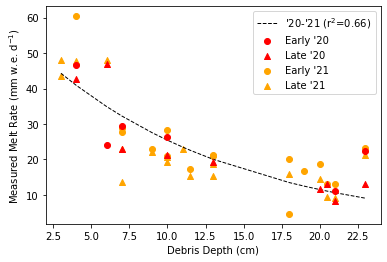

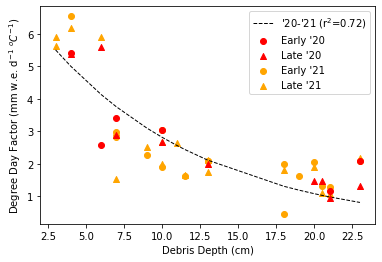

In [20]:
main()